<center>
  <img src="https://www.iasonltd.com/logo_full.svg" alt="Polimi Logo" width="200">
  <h4></h4>
  <h1> GenAI for Data Analysis </h1>
</center>

# Introduction

Welcome to the **GenAI for Data Analysis Challenge!** In this notebook, you'll explore how to leverage **Generative AI** techniques for data analysis, focusing on tool and model structures using **LangChain** with a Large Language Model (LLM), **LLaMA**. Your goal will be to analyze a **Yahoo Finance dataset** and build a model capable of generating automatic summaries and providing feedback based on user queries.

As part of this challenge, you will learn:

- **Prompt engineering**: Learn how to craft effective prompts that guide the LLM to produce accurate and relevant results.
- **Binding tools to the LLM**: Discover how to enhance the LLM’s functionality by integrating external tools, making it more versatile and capable of complex data operations.
- **Utilizing LangGraph**: A key part of the challenge will involve working with **LangGraph**, a powerful framework that simplifies the process of connecting different tools and models, allowing you to build more dynamic and interactive AI systems.

By the end of this notebook, you will have hands-on experience in setting up a robust AI pipeline that transforms raw data into actionable insights and user-friendly summaries, all through the seamless integration of LangChain.


## Overview of LangChain

**LangChain** is a versatile framework designed to simplify the development of applications that leverage large language models (LLMs). It offers abstractions for creating custom tools, managing prompts and templates, handling conversational memory, and orchestrating complex workflows. LangChain empowers developers to build sophisticated data agents that interact seamlessly with various data sources and provide intelligent, context-aware responses.

**Key Features:**


*   **Prompt Management:** Create and manage dynamic prompts and templates.
*   **Tool Integration:** Connect LLMs with external APIs and data sources.
*   **Memory Handling:** Maintain conversational context and state across interactions.
*   **Chain Building:** Orchestrate multi-step processes and workflows.



For comprehensive documentation, visit the [LangChain Documentation](https://python.langchain.com/docs/introduction/#:~:text=LangChain%20is%20a%20framework%20for%20developing).

## Environment Setup

Before diving into the implementation, ensure that all necessary libraries are installed. This setup includes LangChain, Hugging Face Transformers, and other essential packages for data handling and visualization.

In [1]:
# Install required libraries
!pip install langchain transformers pandas matplotlib torch huggingface_hub langchain_huggingface langgraph langchain-ollama langchain_experimental duckduckgo-search --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.1/208.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.7/407.7 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.9/296.9 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/5

*Note: The `--quiet` flag suppresses installation logs for a cleaner notebook interface.* *italicized text*

## Import Libraries

Import all necessary libraries for data manipulation, modeling, and LangChain functionalities.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch

# LangChain imports
from langchain import LLMChain, PromptTemplate
from langchain_huggingface.llms import HuggingFacePipeline
from langchain.agents import Tool, initialize_agent

from IPython.display import clear_output
import os
import threading
import subprocess
import requests
import json

from langchain_ollama import ChatOllama
from langchain_core.tools import tool
from langchain_core.messages import ToolMessage
from langchain_core.messages import HumanMessage
from langchain_core.messages.system import SystemMessage
import operator
from typing import Annotated, Sequence, TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import BaseMessage
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from typing import List
from typing import Tuple, Dict, Any
from langchain_core.prompts import (ChatPromptTemplate,AIMessagePromptTemplate, MessagesPlaceholder)
from langchain_core.messages import ToolMessage
from langchain.schema import HumanMessage, AIMessage
from langgraph.prebuilt import ToolInvocation
from langchain_core.runnables import RunnableLambda
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
from langgraph.graph import END, StateGraph, START
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_experimental.utilities import PythonREPL

#  Data Acquisition and Exploration

In [3]:
url_historical_1 = 'https://raw.githubusercontent.com/havvanilsuoz/polimi_fintech/refs/heads/main/data/historical_data_1.csv'
url_historical_2 = 'https://raw.githubusercontent.com/havvanilsuoz/polimi_fintech/refs/heads/main/data/historical_data_2.csv'
url_metadata = 'https://raw.githubusercontent.com/havvanilsuoz/polimi_fintech/refs/heads/main/data/metadata.csv'
url_largest_companies = 'https://raw.githubusercontent.com/havvanilsuoz/polimi_fintech/refs/heads/main/data/largest_companies.csv'

In [4]:
historical_1 = pd.read_csv(url_historical_1)
historical_2 = pd.read_csv(url_historical_2)

historical_df = pd.concat([historical_1, historical_2], ignore_index=True)

In [5]:
historical_df.head()

,date,open,high,low,close,volume,split_ratio,dividend,symbol,capital_gains
0,2023-01-03,68.635002,69.209999,68.065002,68.480003,3541400,0.0,0.0,NVO,NaN
1,2023-01-04,69.330002,69.334999,68.029999,68.385002,2777400,0.0,0.0,NVO,NaN
2,2023-01-05,67.775002,68.574997,67.690002,68.125000,3049400,0.0,0.0,NVO,NaN
3,2023-01-06,68.504997,69.525002,68.254997,69.320000,2308000,0.0,0.0,NVO,NaN
4,2023-01-09,69.370003,69.525002,68.474998,68.614998,2418800,0.0,0.0,NVO,NaN


In [ ]:
len(historical_df['symbol'].unique())

1664

In [6]:
metadata_df = pd.read_csv(url_metadata, index_col='symbol')
metadata_df.head()

,country,industry,sector,longBusinessSummary,dividendRate,dividendYield,payoutRatio,beta,trailingPE,forwardPE,...,currentRatio,totalRevenue,debtToEquity,revenuePerShare,returnOnAssets,returnOnEquity,freeCashflow,operatingCashflow,operatingMargins,financialCurrency
symbol,,,,,,,,,,,,,,,,,,,,,
NVO,Denmark,Biotechnology,Healthcare,"Novo Nordisk A/S, together with its subsidiari...",1.45,0.0123,0.4702,0.148,39.676270,28.001198,...,0.945,2.580030e+11,50.710,57.802000,0.22798,0.88572,5.448838e+10,1.153340e+11,0.46480,DKK
MC.PA,France,Luxury Goods,Consumer Cyclical,"LVMH Moët Hennessy - Louis Vuitton, Société Eu...",13.00,0.0204,0.4653,0.963,21.374374,17.305130,...,1.381,8.559000e+10,61.449,171.319000,0.09632,0.23210,9.772125e+09,1.893400e+10,0.25573,EUR
ASML,Netherlands,Semiconductor Equipment & Materials,Technology,"ASML Holding N.V. develops, produces, markets,...",6.65,0.0091,0.3517,NaN,35.783710,21.677864,...,1.551,2.623710e+10,29.051,1.200402,0.12707,0.49216,4.977000e+08,4.818400e+09,0.32692,EUR
SAP,Germany,Software - Application,Technology,"SAP SE, together with its subsidiaries, provid...",2.39,0.0104,1.0195,0.921,96.974580,33.955490,...,1.120,3.254300e+10,20.820,27.898000,0.06575,0.06100,9.452000e+09,7.389000e+09,0.23417,EUR
RMS.PA,France,Luxury Goods,Consumer Cyclical,Hermès International Société en commandite par...,15.00,0.0071,0.3534,0.706,48.186530,40.797607,...,4.108,1.423300e+10,14.465,135.870000,0.19178,0.31544,3.285375e+09,4.466000e+09,0.42124,EUR


In [7]:
metadata_df.shape

(1664, 49)

In [ ]:
metadata_df.to_csv('metadata.csv')

# Setting Up the Language Model

This code first installs `pciutils`, a set of tools used to manage PCI devices on the system. Then, it downloads and installs the Ollama API by executing a shell script fetched from the Ollama website using `curl`.

In [8]:
!sudo apt-get install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh # download ollama api

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libpci3 pci.ids
The following NEW packages will be installed:
  libpci3 pci.ids pciutils
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 343 kB of archives.
After this operation, 1,581 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 pci.ids all 0.0~2022.01.22-1 [251 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libpci3 amd64 1:3.7.0-6 [28.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 pciutils amd64 1:3.7.0-6 [63.6 kB]
Fetched 343 kB in 1s (588 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 3.)
debconf: falling back to frontend: Readline
debconf: unable to initializ

The function `ollama()` configures the environment for the Ollama API by setting the `OLLAMA_HOST` to `0.0.0.0:11434` and allowing all origins through the `OLLAMA_ORIGINS` environment variable. It then starts the Ollama server by invoking the `ollama serve` command in a subprocess. A separate thread is initiated using Python's `threading` module to run the `ollama()` function concurrently, enabling the server to operate in the background while the main program continues execution.


In [9]:
def ollama():
    os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])

ollama_thread = threading.Thread(target=ollama)
ollama_thread.start()
clear_output()

The command `!ollama pull llama3.2:3b` pulls the specific version `3b` of the `Llama 3.2` model using the Ollama API. After the model is downloaded, the `clear_output()` function is used to clear the output of the current cell, keeping the notebook interface clean. Additionally, different versions of the Llama model can be selected by specifying alternative version tags in the command, depending on the desired model size or version.


In [10]:
!ollama pull llama3.2:3b
clear_output()

The `ChatOllama` object from LangChain is initialized with the `llama3.2:3b` model. We set the `temperature` to `0` for deterministic responses and `num_predict` to `-1` to allow unlimited token generation. LangChain's `ChatOllama` is used for seamless integration with the Ollama API, simplifying model interaction.


In [11]:
model = ChatOllama(model="llama3.2:3b", temperature = 0, num_predict = -1)

Let's try out the model! You can ask queries to observe how the model responds to various inputs.

In [ ]:
model.invoke("Hello, how are you?")

AIMessage(content="I'm just a language model, so I don't have emotions or feelings like humans do. However, I'm functioning properly and ready to assist you with any questions or tasks you may have! How can I help you today?", additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2024-10-21T08:39:34.830016373Z', 'message': {'role': 'assistant', 'content': ''}, 'done_reason': 'stop', 'done': True, 'total_duration': 12084662698, 'load_duration': 10327188584, 'prompt_eval_count': 31, 'prompt_eval_duration': 161301000, 'eval_count': 47, 'eval_duration': 1543823000}, id='run-7db86df1-8ebf-48f6-8e23-f99fec93d505-0', usage_metadata={'input_tokens': 31, 'output_tokens': 47, 'total_tokens': 78})

## Prompt Example

In [ ]:
example_prompt_template = """
Act as a Socrates and answer the question.

Question: {question}

Answer:

"""

example_prompt = ChatPromptTemplate.from_template(example_prompt_template)

In [ ]:
model_v1 = example_prompt | model

In [ ]:
model_v1.invoke({"question": "How are you?"})

AIMessage(content='My young friend, I must ask you to consider what it means to say "I am." Is it not a fleeting concept, a momentary state of being? Can we truly know ourselves at any given time? Or are we merely shadows of our former selves, like the silhouettes cast by the sun on the wall?\n\nTo answer your question, I must first ask: what do you mean by "I am"? Are you referring to my physical body, which is subject to the whims of fate and the passage of time? Or are you speaking of my soul, which is a realm of eternal existence and wisdom?\n\nTell me, how can we truly know ourselves, when our perceptions are filtered through the lens of our senses and our understanding is shaped by our experiences and biases? Can we not be like the river, ever-changing and flowing, yet remaining constant in its essence?\n\nSo, I must ask you again: what do you mean by "I am"? And how can we truly know ourselves, when we are but a mere reflection of the infinite and mysterious universe that surrou

## Tool Example

In [ ]:
@tool
def get_current_weather(location: str) -> str:
    """Get the current weather in a given location"""

    return "sunny"

In [ ]:
model_v2 = model.bind_tools(tools=[get_current_weather])

In [ ]:
query = "What is the weather in Milan?"
messages = [HumanMessage(query)]
response_1 = model_v2.invoke(messages)
print(response_1)

content='' additional_kwargs={} response_metadata={'model': 'llama3.2:3b', 'created_at': '2024-10-21T08:59:40.110926217Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'get_current_weather', 'arguments': {'location': 'Milan'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 454557726, 'load_duration': 25444836, 'prompt_eval_count': 162, 'prompt_eval_duration': 24758000, 'eval_count': 19, 'eval_duration': 362408000} id='run-aca5c6d8-1b26-4cab-a3c0-72863ffb7ee6-0' tool_calls=[{'name': 'get_current_weather', 'args': {'location': 'Milan'}, 'id': 'f47e2abf-0036-4584-a7f2-64a0d437a357', 'type': 'tool_call'}] usage_metadata={'input_tokens': 162, 'output_tokens': 19, 'total_tokens': 181}


In [ ]:
messages.append(response_1)

for tool_call in response_1.tool_calls:
    selected_tool = {"get_current_weather": get_current_weather}[tool_call["name"].lower()]
    tool_msg = selected_tool.invoke(tool_call)
    messages.append(tool_msg)

messages

[HumanMessage(content='What is the weather in Milan?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2024-10-21T08:59:40.110926217Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'get_current_weather', 'arguments': {'location': 'Milan'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 454557726, 'load_duration': 25444836, 'prompt_eval_count': 162, 'prompt_eval_duration': 24758000, 'eval_count': 19, 'eval_duration': 362408000}, id='run-aca5c6d8-1b26-4cab-a3c0-72863ffb7ee6-0', tool_calls=[{'name': 'get_current_weather', 'args': {'location': 'Milan'}, 'id': 'f47e2abf-0036-4584-a7f2-64a0d437a357', 'type': 'tool_call'}], usage_metadata={'input_tokens': 162, 'output_tokens': 19, 'total_tokens': 181}),
 ToolMessage(content='sunny', name='get_current_weather', tool_call_id='f47e2abf-0036-4584-a7f2-64a0d437a357')]

In [ ]:
response_2 = model_v2.invoke(messages)

response_2

AIMessage(content='The current weather in Milan is sunny.', additional_kwargs={}, response_metadata={'model': 'llama3.2:3b', 'created_at': '2024-10-21T09:00:02.012881475Z', 'message': {'role': 'assistant', 'content': 'The current weather in Milan is sunny.'}, 'done_reason': 'stop', 'done': True, 'total_duration': 511798975, 'load_duration': 78037440, 'prompt_eval_count': 94, 'prompt_eval_duration': 62412000, 'eval_count': 9, 'eval_duration': 242419000}, id='run-60d96051-6101-4d7b-83c3-599be76854a5-0', usage_metadata={'input_tokens': 94, 'output_tokens': 9, 'total_tokens': 103})

# Challenge

## Tools

In the context of AI systems, tools refer to functions or utilities that an AI model can invoke to perform specific tasks outside of its core capabilities. These tools can be anything from running code, querying a database, retrieving information from an API, or generating reports.

In LangChain, a popular framework for building applications with large language models (LLMs), tools are often integrated into the workflow to enhance the LLM’s ability to process, analyze, and interact with structured data or external systems. LangChain allows developers to create agents—autonomous entities that use LLMs in conjunction with tools to achieve goals. These agents can call tools during a conversation to fetch relevant data, perform calculations, or automate tasks based on the inputs received from users.

LangChain integrates these tools seamlessly, allowing for dynamic and flexible systems that can interact with databases, APIs, and other services to provide more relevant and context-specific responses.

### Tool 1: Report

In [13]:
def prepare_data():
    metrics = [
        'profitMargins', 'returnOnEquity', 'returnOnAssets',
        'trailingPE', 'forwardPE'
    ]
    # Convert percentage strings to floats and rename columns
    for col in metrics:
        if col in metadata_df.columns:
            metadata_df[col] = metadata_df[col].apply(lambda x: float(str(x).rstrip('%')) / 100 if isinstance(x, str) else x)

    # Rename columns for clarity
    return metadata_df.rename(columns={
        'profitMargins': 'Profit Margins',
        'returnOnEquity': 'ROE',
        'returnOnAssets': 'ROA',
        'trailingPE': 'P/E (Trailing)',
        'forwardPE': 'P/E (Forward)'
    })


def generate_comparison_table(metadata_renamed):
        columns = ['Profit Margins', 'ROE', 'ROA', 'P/E (Trailing)', 'P/E (Forward)']
        table = metadata_renamed[['shortName'] + columns].set_index('shortName')
        return table.to_markdown()


def analyze_companies(metadata_renamed):
    analysis = []
    for _, company in metadata_renamed.iterrows():
        strengths = []
        weaknesses = []

        # Analyze strengths and weaknesses
        if company['Profit Margins'] > metadata_renamed['Profit Margins'].median():
            strengths.append(f"strong profit margins ({company['Profit Margins']:.2%})")
        else:
            weaknesses.append(f"lower profit margins ({company['Profit Margins']:.2%})")

        if company['ROE'] > metadata_renamed['ROE'].median():
            strengths.append(f"high return on equity ({company['ROE']:.2%})")
        else:
            weaknesses.append(f"lower return on equity ({company['ROE']:.2%})")

        if company['ROA'] > metadata_renamed['ROA'].median():
            strengths.append(f"high return on assets ({company['ROA']:.2%})")

        if company['P/E (Trailing)'] < metadata_renamed['P/E (Trailing)'].median():
            strengths.append("lower P/E ratio compared to peers")
        else:
            weaknesses.append("higher P/E ratio compared to peers")

        if company['enterpriseToEbitda'] < metadata_renamed['enterpriseToEbitda'].median():
            strengths.append(f"low enterprise-to-EBITDA ratio ({company['enterpriseToEbitda']:.2f})")
        else:
            weaknesses.append(f"high enterprise-to-EBITDA ratio ({company['enterpriseToEbitda']:.2f})")

        # Convert lists to readable text
        strengths_text = ", ".join(strengths) if strengths else "No notable strengths."
        weaknesses_text = ", ".join(weaknesses) if weaknesses else "No significant weaknesses."

        # Append to analysis list
        analysis.append({
            'Company': company['shortName'],
            'Strengths': strengths_text,
            'Weaknesses': weaknesses_text
        })

    # Convert the analysis into a DataFrame
    analysis_df = pd.DataFrame(analysis)

    # Return the markdown version of the DataFrame
    return analysis_df.to_markdown(index=False)


def get_company_details(metadata_renamed_top):
  columns = ['shortName', 'marketCap', 'fiftyTwoWeekLow','fiftyTwoWeekHigh']
  # Step 1: Get the most recent closing price for each symbol in 'metadata_renamed_top'
  # First, ensure that 'date' is in datetime format
  historical_df['date'] = pd.to_datetime(historical_df['date'])

  # Sort by 'symbol' and 'date' to ensure we get the latest 'close' price for each symbol
  historical_df_filtered = historical_df[historical_df['symbol'].isin(metadata_renamed_top.index)] \
                  .sort_values(by=['symbol', 'date'])
  # Create an empty list to store the results, which is more efficient than DataFrame concatenation
  results = []

  # Iterate over each symbol to calculate the 6-month returns
  symbols = historical_df_filtered['symbol'].unique()

  for symbol in symbols:
      # Filter the data for the current symbol
      symbol_data = historical_df_filtered[historical_df_filtered['symbol'] == symbol]

      # Get the most recent closing price (last close)
      most_recent_data = symbol_data.iloc[-1]  # Last row for this symbol
      most_recent_price = most_recent_data['close']
      most_recent_date = most_recent_data['date']

      # Find the date six months before the most recent date
      six_months_ago_date = most_recent_date - pd.DateOffset(months=6)

      # Filter for the closest date to six months ago for this symbol
      six_months_ago_data = symbol_data[symbol_data['date'] <= six_months_ago_date]

      if not six_months_ago_data.empty:  # Make sure there is data 6 months ago
          six_months_ago_price = six_months_ago_data.iloc[-1]['close']  # Get the closest price

          # Calculate the six-month return
          six_month_return = ((most_recent_price - six_months_ago_price) / six_months_ago_price) * 100

          # Append the result as a dictionary to the list
          results.append({
              'symbol': symbol,
              'currentPrice': most_recent_price,
              'priceSixMonthsAgo': six_months_ago_price,
              'return': six_month_return
          })

  # Convert the results list to a DataFrame
  returns_df = pd.DataFrame(results)

  # Step 2: Merge the latest prices with 'metadata_renamed_top'
  metadata_renamed_top_with_value = metadata_renamed_top.merge(
      returns_df, left_on=metadata_renamed_top.index, right_on='symbol', how='left'
  )

  # Step 3: Create the 'details' DataFrame with 'currentValue' included
  details = metadata_renamed_top_with_value[columns + ['currentPrice', 'priceSixMonthsAgo', 'return']].set_index('shortName').to_markdown()

  return details

def plot_top_5_historical(metadata_renamed_top):
  # Ensure symbol_list is a list, even if passed as a string representation
  symbol_list = metadata_renamed_top.index.tolist()
  historical_df_filtered = historical_df[historical_df['symbol'].isin(symbol_list)]

  plt.figure(figsize=(8, 4))
  plt.title(f'Historical Price Data for {symbol_list}')
  plt.xlabel('Date')
  plt.ylabel('Price')

  for symbol in symbol_list:
    condition = (historical_df_filtered['symbol'] == symbol)

    # Filter the historical data for the specified symbol and date range
    symbol_data = historical_df_filtered[condition]

    # Create a line plot of the historical data

    plt.plot(symbol_data['date'], symbol_data['close'], label = symbol)

  plt.legend()
  plt.xticks(rotation=45)

  # Format the x-axis to display fewer date ticks
  plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
  plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

  # Rotate the x-axis labels for better readability
  plt.gcf().autofmt_xdate()

  # Tight layout
  plt.tight_layout()

  # Save the plot as an image file
  plot_filename = 'top_5_historical_plot.png'
  plt.savefig(plot_filename)
  plt.close()

def plot_sector_distribution(sector_distribution):
  # Dynamically calculate explode based on the number of sectors
  num_sectors = len(sector_distribution)
  explode = [0.05] * num_sectors
  # Dynamically adjust the size and distance based on the number of slices
  label_distance = 1.1 if num_sectors <= 10 else 1.2  # Adjust label distance dynamically
  pct_distance = 0.75 if num_sectors <= 10 else 0.85  # Adjust percentage distance dynamically

  plt.figure(figsize=(5, 5))
  plt.pie(
      sector_distribution,
      labels=sector_distribution.index,
      autopct='%1.1f%%',
      startangle=90,
      explode=explode,    # Dynamically exploded slices for spacing
      pctdistance=pct_distance,   # Adjust distance of percentage labels
      labeldistance=label_distance,  # Adjust distance of labels from the center
      textprops={'fontsize': 8}  # Reduce font size to prevent percentage overlap
  )
  # Equal aspect ratio ensures that pie is drawn as a circle.
  plt.axis('equal')
  plt.title('Sector Distribution', fontweight='bold', y=1.01)
  plt.tight_layout()
  plt.savefig('sector_distribution.png')
  plt.close()

@tool
def generate_report() -> Tuple[Dict[str, Any], str, str, str]:
    """
    Generates a comprehensive financial analysis report for a set of companies.

    Returns:
        Tuple[Dict[str, Any], str, str, str]:
            - Dictionary of data insights containing metadata such as total companies and sector distribution.
            - Markdown-formatted comparison table of key metrics.
            - Markdown-formatted analysis of companies' strengths and weaknesses.
            - Markdown-formatted table of company details.
    """
    metadata_renamed = prepare_data()
    metadata_renamed_top = metadata_renamed[:5]
    comparison_table = generate_comparison_table(metadata_renamed_top)
    company_analysis = analyze_companies(metadata_renamed_top)
    company_details = get_company_details(metadata_renamed_top)

    sector_distribution = metadata_df.groupby(by='sector').size()


    data_insights = {
        'Total Companies': len(metadata_renamed),
        'Total Companies by Sector': sector_distribution.to_json(),
    }

    plot_sector_distribution(sector_distribution)
    plot_top_5_historical(metadata_renamed_top)

    return data_insights, comparison_table, company_analysis, company_details


### Tool 2: Plot Historical Data

In [101]:
import ast

@tool
def plot_historical_price_data(symbol_list, start_date: str = None, end_date: str = None) -> str:
    """
    Plots historical price data for a list of stock symbols within an optional date range.

    Args:
        symbol_list (List[str]): List of stock symbols to plot such as ["AAPL", "MSFT", "GOOGL"].
        start_date (str, optional): Start date ('YYYY-MM-DD'). Defaults to None (all available data).
        end_date (str, optional): End date ('YYYY-MM-DD'). Defaults to None (all available data).

    Returns:
        str: File path to the saved plot image ('historical_plot.png').
    """

    # Handle the case where symbol_list is passed as a string representation of a list
    if isinstance(symbol_list, str):
        try:
            symbol_list = ast.literal_eval(symbol_list)  # Safely convert the string representation to a list
        except (ValueError, SyntaxError):
            raise ValueError("Invalid format for symbol_list. Must be a list or a string representing a list.")

    historical_df['date'] = pd.to_datetime(historical_df['date'])

    plt.figure(figsize=(12, 6))
    plt.title(f'Historical Price Data for {symbol_list}')
    plt.xlabel('Date')
    plt.ylabel('Price')

    for symbol in symbol_list:
        condition = (historical_df['symbol'] == symbol)
        if start_date:
            condition &= (historical_df['date'] >= start_date)
        if end_date:
            condition &= (historical_df['date'] <= end_date)
        # Filter the historical data for the specified symbol and date range
        symbol_data = historical_df[condition]

        # Create a line plot of the historical data
        plt.plot(symbol_data['date'], symbol_data['close'], label=symbol)

    plt.legend()
    plt.xticks(rotation=45)

    # Format the x-axis to display fewer date ticks
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Rotate the x-axis labels for better readability
    plt.gcf().autofmt_xdate()

    # Tight layout
    plt.tight_layout()

    # Save the plot as an image file
    plot_filename = 'historical_plot.png'
    plt.savefig(plot_filename)
    plt.close()

    return_message = f"Historical price data plot for {symbol_list} is saved in path {plot_filename}"
    # Return the path to the saved plot image file
    return return_message

### Tool 3: Get Column Names

In [15]:
@tool
def get_column_names() -> List[str]:
    """
    Returns a list of all available column names from the metadata dataframe.

    This tool can be used to retrieve the available metrics (columns) from the metadata,
    which may include numerical values (such as 'revenueGrowth', 'profitMargins') and other
    metadata columns (such as 'shortName', 'industry').

    Use this tool to get the names of the columns in the metadata before using `get_largest_metric` tool. Make sure you choose the correct name based on the query.

    Returns:
        List[str]: A list of column names in the metadata dataframe.

    Example:
        You can call this function to get all available columns and select the appropriate one:
        get_column_names()
    """
    return metadata_df.columns.to_list()

### Tool 4: Get the Largest

In [169]:
@tool
def get_largest_metric(column_name: str, top: int = 3) -> str:
    """
    Returns the names and metric values of the top companies with the largest value for the given column_name.

    Args:
        column_name (str): The name of the column representing the desired metric from the metadata dataframe.
                      The metric should correspond to a numerical column in the dataset (e.g., 'revenueGrowth', 'profitMargins').
                      You should use the `get_column_names` tool to fetch the correct representation of the desired metric.
        top (int, optional): The number of top companies to return based on the largest values of the metric.
                             Defaults to 3.

    Returns:
        str: A string containing the names of the top companies and their corresponding metric values,
             sorted in descending order of the metric.

    Example:
        If you want to find the top 3 companies based on 'revenueGrowth', call the function like this:
        get_largest_metric('revenueGrowth', top=3)
    """
    try:
      # Ensure the metric column is treated as float for sorting
      metadata_df[column_name] = metadata_df[column_name].astype(float)

      # Sort the dataframe by the specified metric in descending order
      sorted_df = metadata_df.sort_values(by=column_name, ascending=False)

      # Return the top N companies and their corresponding metric values
      return sorted_df[['shortName', column_name]].head(top)

    except Exception:
      return "Please send the correct column name. Make a tool call to 'get_column_names' tool to see the available options."


### Tool 5: Search

In [17]:
search = DuckDuckGoSearchRun(
    name="search",
    description="Useful for when you need to answer questions about detailed explaination and news of tickers or companies. You should ask targeted questions.",
)

### Tool 6: Ticker Description

In [18]:
@tool
def ticker_description(symbol: str) -> str:
    """
    Returns the descriptive statistics for the given symbol from the historical_df DataFrame.

    Args:
        symbol (str): The stock ticker symbol to filter.

    Returns:
        str: The .describe() output for the symbol's historical data in markdown format.
    """
    # Filter the DataFrame by the provided symbol
    filtered_data = historical_df[historical_df['symbol'] == symbol]

    # Check if the symbol exists in the DataFrame
    if filtered_data.empty:
        return f"No data found for symbol: {symbol}"

    # Get the descriptive statistics using .describe()
    description = filtered_data[['open','high','low', 'close', 'volume']].describe().round(2)


    return description

## Prompts

### Prompt 1: Chat

In [191]:
chat_prompt_template = """
You are a highly proficient assistant specializing in financial analysis.
Based on the question you can call the relevant tools.

Never guess, fabricate, or present information without reliable data sources.
Maintain clarity, precision, and professionalism in all responses.

Do not trying to import data, stick to the tool calls.

Always represent numbers with a thousand separator (e.g., 10,000,000 instead of 1e7 or 10000000).

"""

### Prompt 2: Report

In [20]:
report_prompt_template = """
You are a financial analyst. Given the tool result, your task is to create a comprehensive financial analysis report for a set of companies.
You should not fabricate any data or hallucinate, and always base your report on the tool's response.

Report structure should be as below:

  # Financial Analysis Report

  ## Dataset Overview
    - Explain the total number of companies in the dataset and provide a sector breakdown.

  ## Company Overview
    - Explain that the report consists of top 5 companies analysis
    - List and describe the companies included in the analysis.

  ## Comparison Table
    - Create a table that compares the key metrics (Profit Margins, ROE, ROA, P/E ratios) across all the companies.
    - Then write a paragraph of conclusions based on the metrics.

  ## Company Analysis
    - Create a table of the strengths and weaknesses of all companies.
    - Then write a paragraph of conclusions based on the metrics

  ## Market Capitalization and Price History
    - Create a table that compares the key metrics (Market Cap, Fifty Two Week Low, Fifty Two Week High, Current Price, Price Six Months Ago and Return) across all the companies.
    - Then write a paragraph of conclusions based on the metrics.

  ## Key Insights
    - Highlight the major findings from the analysis, such as notable trends or outliers in the companies' performance metrics.
    - Include any additional observations based on the data.

You should strictly use the above titles.
"""

In [21]:
import base64
from IPython.display import display, Markdown

def insert_image_as_base64(report: str) -> str:
    """
    Inserts a base64-encoded image into the markdown content before the '## Comparison Table' section.

    Args:
        report (str): The original markdown report.
        image_path (str): Path to the local image file to be inserted.

    Returns:
        str: The updated report with the base64-encoded image.
    """

    # Read the image file and encode it to base64
    with open('sector_distribution.png', "rb") as img_file:
        base64_string_sector = base64.b64encode(img_file.read()).decode('utf-8')

    # Create the base64 markdown image syntax
    image_markdown_sector = f"![Sector Distribution](data:image/png;base64,{base64_string_sector})\n\n"

    # Insert the base64 image before the '## Comparison Table' section
    comparison_table_index = report.find("## Company Overview")
    if comparison_table_index != -1:
        report = report[:comparison_table_index] + image_markdown_sector + report[comparison_table_index:]

    # Read the image file and encode it to base64
    with open('top_5_historical_plot.png', "rb") as img_file:
        base64_string_historical = base64.b64encode(img_file.read()).decode('utf-8')

    # Create the base64 markdown image syntax
    image_markdown_historical = f"![Historical Distribution](data:image/png;base64,{base64_string_historical})\n\n"

    # Insert the base64 image after the '## Market Capitalization and Price History' section
    comparison_table_index = report.find("## Market Capitalization and Price History")
    if comparison_table_index != -1:
        # Find the next line break after the title
        next_line_index = report.find("\n", comparison_table_index)

        # Insert the image after the title
        if next_line_index != -1:
            report = report[:next_line_index + 1] + image_markdown_historical + report[next_line_index + 1:]

    return report

## LangGraph

In [192]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

In [193]:
tools = [generate_report, plot_historical_price_data, get_column_names, get_largest_metric, search, ticker_description]
model_with_tool = model.bind_tools(tools)

In [194]:
def chatbot(state: AgentState):
  messages = state['messages']
  if messages and isinstance(messages[-1], ToolMessage):
    if messages[-1].name == "generate_report":
      prompt_template = report_prompt_template
    else:
      prompt_template = chat_prompt_template

  else:
    prompt_template = chat_prompt_template

  prompt = ChatPromptTemplate.from_messages(prompt_template)

  # Create the HumanMessage from the chosen template
  prompt_message = SystemMessage(content=prompt_template)

  # Add the prompt to the messages list
  messages_with_prompt = [prompt_message] + messages

  # Invoke the model with the current messages and prompt
  response = model_with_tool.invoke(messages_with_prompt)

  if messages[-1].name == "generate_report":
    response.content = insert_image_as_base64(response.content)

  #response = model_with_tool.invoke(messages)
  return {"messages": [response]}

In [195]:
def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def handle_tool_error(state: AgentState) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


In [196]:
def should_continue(state: AgentState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tool_node"
    return END

In [197]:
# Define a new graph
workflow = StateGraph(AgentState)

workflow.add_node('chatbot', chatbot)
workflow.add_node('tool_node', create_tool_node_with_fallback(tools))

workflow.add_edge(START, 'chatbot')
workflow.add_conditional_edges('chatbot', should_continue)

workflow.add_edge("tool_node", "chatbot")

app = workflow.compile()


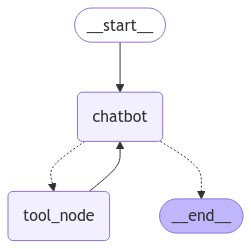

In [198]:
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

# Trials

## Report

In [29]:
response = app.invoke({"messages": ("user", "Can you generate the report?")})

# Financial Analysis Report

## Dataset Overview
The dataset consists of 1664 companies across various sectors, including Basic Materials, Communication Services, Consumer Cyclical, Consumer Defensive, Energy, Financial Services, Healthcare, Industrials, Real Estate, Technology, and Utilities.

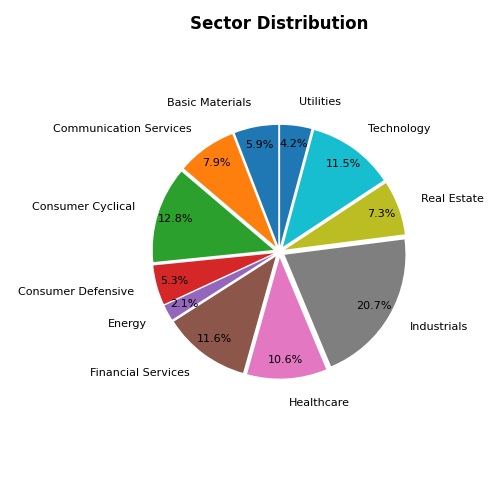

## Company Overview
This report focuses on the top 5 companies in the analysis:

1. Novo Nordisk A/S
2. LVMH
3. ASML Holding N.V. - New York Re
4. SAP  SE
5. HERMES INTL

## Comparison Table
| Company                         | Profit Margins |     ROE |     ROA |   P/E (Trailing) |   P/E (Forward) |
|:--------------------------------|:-----------------:|--------:|--------:|-----------------:|----------------:|
| Novo Nordisk A/S                |          0.34844 | 0.88572 | 0.22798 |          39.6763 |         28.0012 |
| LVMH                            |          0.1631  | 0.2321  | 0.09632 |          21.3744 |         17.3051 |
| ASML Holding N.V. - New York Re |          0.26399 | 0.49216 | 0.12707 |          35.7837 |         21.6779 |
| SAP  SE                         |          0.07863 | 0.061   | 0.06575 |          96.9746 |         33.9555 |
| HERMES INTL                     |          0.31286 | 0.31544 | 0.19178 |          48.1865 |         40.7976 |

The comparison table highlights the key financial metrics for each company. Novo Nordisk A/S has strong profit margins and high return on equity, while LVMH has lower profit margins but a low enterprise-to-EBITDA ratio. ASML Holding N.V. - New York Re has high return on equity but lower profit margins. SAP  SE has no notable strengths, while HERMES INTL has strong profit margins and high return on assets.

## Company Analysis
| Company                         | Strengths                                                                                                                             | Weaknesses                                                                                                                                |
|:--------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------|
| Novo Nordisk A/S                | strong profit margins (34.84%), high return on equity (88.57%), high return on assets (22.80%), low enterprise-to-EBITDA ratio (4.11) | higher P/E ratio compared to peers                                                                                                        |
| LVMH                            | lower P/E ratio compared to peers, low enterprise-to-EBITDA ratio (14.15)                                                             | lower profit margins (16.31%), lower return on equity (23.21%)                                                                            |
| ASML Holding N.V. - New York Re | high return on equity (49.22%), lower P/E ratio compared to peers                                                                     | lower profit margins (26.40%), high enterprise-to-EBITDA ratio (32.36)                                                                    |
| SAP  SE                         | No notable strengths.                                                                                                                 | lower profit margins (7.86%), lower return on equity (6.10%), higher P/E ratio compared to peers, high enterprise-to-EBITDA ratio (32.70) |
| HERMES INTL                     | strong profit margins (31.26%), high return on assets (19.18%)                                                         | no notable weaknesses mentioned in the dataset |

The company analysis highlights the strengths and weaknesses of each company. Novo Nordisk A/S has strong financial performance, while LVMH has a low enterprise-to-EBITDA ratio. ASML Holding N.V. - New York Re has high return on equity but lower profit margins. SAP  SE has no notable strengths, while HERMES INTL has strong profit margins and high return on assets.

## Market Capitalization and Price History
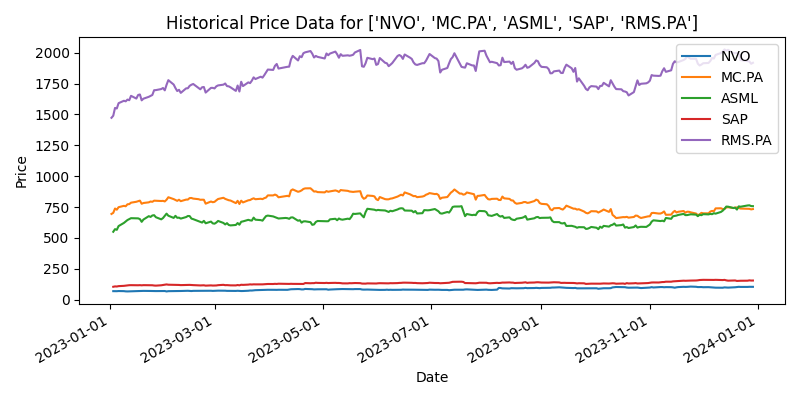

| Company                         |   marketCap |   fiftyTwoWeekLow |   fiftyTwoWeekHigh |   currentPrice |   priceSixMonthsAgo |    return |
|:--------------------------------|------------:|------------------:|-------------------:|---------------:|--------------------:|----------:|
| Novo Nordisk A/S                | 5.18733e+11 |             92.94 |             148.15 |         103.45 |              78.515 |  31.7583  |
| LVMH                            | 3.05256e+11 |            578.8  |             886.4  |         733.6  |             855     | -14.1988  |
| ASML Holding N.V. - New York Re | 3.20118e+11 |            573.86 |            1110.09 |         756.92 |             723.35  |   4.64091 |
| SAP  SE                         | 2.68773e+11 |            127.3  |             232.23 |         154.59 |             134.43  |  14.9967  |
| HERMES INTL                     | 2.14494e+11 |           1641    |            2436    |        1918.8  |            1962     |  -2.20183 |

The market capitalization and price history table provides an overview of the current market value and historical prices for each company. Novo Nordisk A/S has a high market capitalization, while LVMH has a low fifty-two week low. ASML Holding N.V. - New York Re has a high fifty-two week high, while SAP  SE has a relatively stable price history. HERMES INTL has a low return over the past six months.

## Conclusion
This financial analysis report provides an overview of the top 5 companies in the dataset, including their key financial metrics, strengths and weaknesses, market capitalization, and price history. The results highlight the importance of considering multiple factors when evaluating a company's financial performance and potential for growth.

In [30]:
from IPython.display import display, Markdown

display(Markdown(response['messages'][-1].content))

## Plot Historical Data

In [109]:
response = app.invoke({"messages": ("user", "Can you plot the historical price data of NVO and ASML from February 2023 to July 2023?")})

In [110]:
display(Markdown(response['messages'][-1].content))

The historical price data plot for NVO and ASML from February 2023 to July 2023 has been generated and saved as a PNG image named "historical_plot.png". The plot displays the closing prices of both stocks over the specified time period. 

If you would like to view the plot, please find it in the path where the tool call was executed.

## Get The Largest ...

In [199]:
response = app.invoke({"messages": ("user", "What are the top 3 companies that has the largest Total Dept?")})

In [205]:
print(response['messages'][-1].content)

The top 3 companies with the largest Total Debt are:

1. OTP Bank PLC - $5,769,124,000,000
2. Svenska Handelsbanken ser. A - $1,734,517,000,000
3. DANSKE BANK AS - $1,583,528,000,000


## Search

In [221]:
response = app.invoke({"messages": ("user", "Can you provide me some details about Novo Nordisk A/S?")})

In [222]:
from IPython.display import Markdown

display(Markdown(response['messages'][-1].content))

Novo Nordisk A/S (NVO) is a Danish multinational pharmaceutical company headquartered in Bagsværd, Denmark. Here are some key details about the company:

**Founding and History**: Novo Nordisk was founded in 1923 by a group of Danish pharmacists.

**Purpose**: The company's purpose is to drive change to defeat serious chronic diseases.

**Business**: Novo Nordisk develops and produces medicines and solutions for diabetes, obesity, and other chronic diseases.

**Headquarters**: The company is headquartered in Bagsværd, Denmark.

**Grants and Initiatives**: Novo Nordisk has initiated various grants and initiatives to support research and development of new treatments for chronic diseases.

**Stock Information**: As of my knowledge cutoff in 2023, the stock ticker for Novo Nordisk A/S is NVO. The company's market capitalization was approximately $123 billion USD.

**R&D Pipeline**: Novo Nordisk has a robust R&D pipeline with several promising candidates in various stages of development, including semaglutide, which has shown significant efficacy in treating type 2 diabetes and obesity.

**Career Opportunities**: Novo Nordisk offers various career opportunities in the pharmaceutical industry, including research and development, sales, marketing, and more.

## Statistics

In [230]:
response = app.invoke({"messages": ("user", "Can you provide me the mean of the historical data of the ticker NVO?")})

In [231]:
from IPython.display import Markdown

print(response['messages'][-1].content)

The mean of the historical data for the ticker NVO is $84.96.


In [226]:
# Filter the DataFrame by the provided symbol
filtered_data = historical_df[historical_df['symbol'] == 'NVO']


# Get the descriptive statistics using .describe()
description = filtered_data[['open','high','low', 'close', 'volume']].describe().round(2)

In [227]:
description

,open,high,low,close,volume
count,250.00,250.00,250.00,250.00,250.00
mean,84.90,85.60,84.21,84.96,3449923.60
std,11.08,11.25,10.94,11.12,1982222.12
min,65.50,66.31,65.05,66.17,1382000.00
25%,77.79,78.56,77.28,78.29,2281700.00
50%,82.82,83.19,82.13,82.76,2898000.00
75%,95.49,96.22,94.69,95.20,3901650.00
max,104.88,105.69,104.15,105.45,17822600.00
